## RKD with CIFAR100

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss
from utils.misc_tools_rkd import best_lr_rkd, rkd_train_teacher, rkd_train_student_with_distillation, rkd_test_model
from utils.compare_tools_rkd import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison


In [2]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [3]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 240
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1
beta = 0.0
patience = 5  # for early stopping

batch_size = 32
# batch_size = 16
num_workers = 2


In [4]:
# Load CIFAR100 dataset
trainloader, testloader  = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = torchvision.models.resnet18(weights=None).cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create instances of your models
teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = CustomResNet18()

# Ensure the final classification layer is added to the model
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(student_model.output_size, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

100%|████████████████████████████████████████████████████████████████████████| 782/782 [09:50<00:00,  1.33it/s]


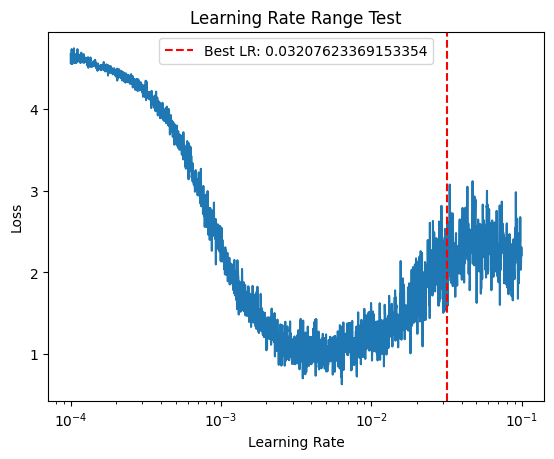

Best learning rate: 0.03207623369153354
0.03207623369153354


In [13]:
batch_size = 16  #to find the optimal learning rate
teacher_best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(teacher_best_lr)

100%|████████████████████████████████████████████████████████████████████████| 782/782 [06:30<00:00,  2.00it/s]


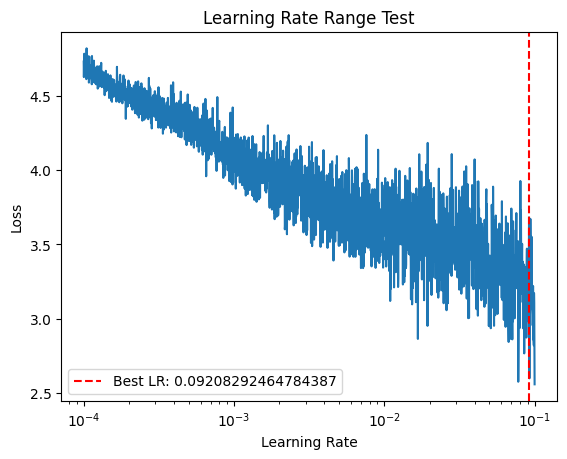

Best learning rate: 0.09208292464784387
0.09208292464784387


In [8]:
student_best_lr = train_teacher(student_model, trainloader, criterion, student_optimizer, student_scheduler, device, num_epochs=3)  
print(student_best_lr)

In [9]:
teacher_learning_rate = 0.03207623369153354
student_learning_rate = 0.09208292464784387



In [10]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            # ce_loss = criterion(student_outputs, labels)
            # kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            # loss = alpha * kd_loss + (1 - alpha) * ce_loss
            distance_loss = RKDDistanceLoss()(student_outputs, teacher_outputs)
            angle_loss = RKDAngleLoss()(student_outputs, teacher_outputs)
            loss = criterion(student_outputs, labels) + 0.1 * (distance_loss + angle_loss)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [15]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, student_optimizer, student_scheduler, device, alpha, temperature, num_epochs=num_epochs)


 13%|█████████▏                                                              | 100/782 [01:25<09:43,  1.17it/s]

[1, 100] loss: 8.284


 26%|██████████████████▍                                                     | 200/782 [02:50<08:15,  1.17it/s]

[1, 200] loss: 7.927


 38%|███████████████████████████▌                                            | 300/782 [04:15<06:41,  1.20it/s]

[1, 300] loss: 7.597


 51%|████████████████████████████████████▊                                   | 400/782 [05:41<05:21,  1.19it/s]

[1, 400] loss: 7.345


 64%|██████████████████████████████████████████████                          | 500/782 [07:06<03:59,  1.18it/s]

[1, 500] loss: 7.144


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:32<02:35,  1.17it/s]

[1, 600] loss: 6.948


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:57<01:09,  1.19it/s]

[1, 700] loss: 6.770


 13%|█████████▏                                                              | 100/782 [01:24<09:34,  1.19it/s]

[2, 100] loss: 6.339


 26%|██████████████████▍                                                     | 200/782 [02:50<08:02,  1.21it/s]

[2, 200] loss: 6.228


 38%|███████████████████████████▌                                            | 300/782 [04:15<06:58,  1.15it/s]

[2, 300] loss: 6.171


 51%|████████████████████████████████████▊                                   | 400/782 [05:40<05:20,  1.19it/s]

[2, 400] loss: 6.111


 64%|██████████████████████████████████████████████                          | 500/782 [07:05<03:58,  1.18it/s]

[2, 500] loss: 5.977


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:31<02:34,  1.18it/s]

[2, 600] loss: 5.892


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:55<01:09,  1.18it/s]

[2, 700] loss: 5.868


 13%|█████████▏                                                              | 100/782 [01:24<09:24,  1.21it/s]

[3, 100] loss: 5.339


 26%|██████████████████▍                                                     | 200/782 [02:49<08:07,  1.19it/s]

[3, 200] loss: 5.317


 38%|███████████████████████████▌                                            | 300/782 [04:14<06:58,  1.15it/s]

[3, 300] loss: 5.399


 51%|████████████████████████████████████▊                                   | 400/782 [05:39<05:22,  1.18it/s]

[3, 400] loss: 5.255


 64%|██████████████████████████████████████████████                          | 500/782 [07:04<03:56,  1.19it/s]

[3, 500] loss: 5.244


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:29<02:32,  1.19it/s]

[3, 600] loss: 5.241


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:54<01:10,  1.17it/s]

[3, 700] loss: 5.157


 13%|█████████▏                                                              | 100/782 [01:25<09:44,  1.17it/s]

[4, 100] loss: 4.597


 26%|██████████████████▍                                                     | 200/782 [02:50<08:19,  1.16it/s]

[4, 200] loss: 4.674


 38%|███████████████████████████▌                                            | 300/782 [04:15<06:57,  1.15it/s]

[4, 300] loss: 4.685


 51%|████████████████████████████████████▊                                   | 400/782 [05:40<05:24,  1.18it/s]

[4, 400] loss: 4.723


 64%|██████████████████████████████████████████████                          | 500/782 [07:05<04:01,  1.17it/s]

[4, 500] loss: 4.650


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:30<02:34,  1.18it/s]

[4, 600] loss: 4.653


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:55<01:09,  1.19it/s]

[4, 700] loss: 4.590


 13%|█████████▏                                                              | 100/782 [01:24<09:45,  1.16it/s]

[5, 100] loss: 4.030


 26%|██████████████████▍                                                     | 200/782 [02:49<08:17,  1.17it/s]

[5, 200] loss: 4.025


 38%|███████████████████████████▌                                            | 300/782 [04:14<06:51,  1.17it/s]

[5, 300] loss: 4.059


 51%|████████████████████████████████████▊                                   | 400/782 [05:40<05:30,  1.15it/s]

[5, 400] loss: 4.084


 64%|██████████████████████████████████████████████                          | 500/782 [07:05<03:57,  1.19it/s]

[5, 500] loss: 4.138


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:30<02:33,  1.19it/s]

[5, 600] loss: 4.159


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:56<01:09,  1.18it/s]

[5, 700] loss: 4.131


 13%|█████████▏                                                              | 100/782 [01:24<09:37,  1.18it/s]

[6, 100] loss: 3.533


 26%|██████████████████▍                                                     | 200/782 [02:49<08:20,  1.16it/s]

[6, 200] loss: 3.471


 38%|███████████████████████████▌                                            | 300/782 [04:14<06:49,  1.18it/s]

[6, 300] loss: 3.480


 51%|████████████████████████████████████▊                                   | 400/782 [05:39<05:24,  1.18it/s]

[6, 400] loss: 3.538


 64%|██████████████████████████████████████████████                          | 500/782 [07:04<04:00,  1.17it/s]

[6, 500] loss: 3.592


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:29<02:33,  1.19it/s]

[6, 600] loss: 3.656


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:54<01:10,  1.17it/s]

[6, 700] loss: 3.604


 13%|█████████▏                                                              | 100/782 [01:25<09:36,  1.18it/s]

[7, 100] loss: 3.140


 26%|██████████████████▍                                                     | 200/782 [02:50<08:06,  1.20it/s]

[7, 200] loss: 3.047


 38%|███████████████████████████▌                                            | 300/782 [04:15<06:57,  1.16it/s]

[7, 300] loss: 3.047


 51%|████████████████████████████████████▊                                   | 400/782 [05:39<05:25,  1.18it/s]

[7, 400] loss: 3.044


 64%|██████████████████████████████████████████████                          | 500/782 [07:04<03:58,  1.18it/s]

[7, 500] loss: 3.085


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:29<02:34,  1.18it/s]

[7, 600] loss: 3.090


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:54<01:09,  1.17it/s]

[7, 700] loss: 3.084


 13%|█████████▏                                                              | 100/782 [01:25<09:40,  1.18it/s]

[8, 100] loss: 2.763


 26%|██████████████████▍                                                     | 200/782 [02:50<08:21,  1.16it/s]

[8, 200] loss: 2.682


 38%|███████████████████████████▌                                            | 300/782 [04:15<06:36,  1.22it/s]

[8, 300] loss: 2.680


 51%|████████████████████████████████████▊                                   | 400/782 [05:40<05:25,  1.17it/s]

[8, 400] loss: 2.711


 64%|██████████████████████████████████████████████                          | 500/782 [07:05<03:57,  1.19it/s]

[8, 500] loss: 2.686


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:30<02:37,  1.16it/s]

[8, 600] loss: 2.691


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:55<01:10,  1.16it/s]

[8, 700] loss: 2.724


 13%|█████████▏                                                              | 100/782 [01:24<09:45,  1.16it/s]

[9, 100] loss: 2.460


 26%|██████████████████▍                                                     | 200/782 [02:50<08:10,  1.19it/s]

[9, 200] loss: 2.420


 38%|███████████████████████████▌                                            | 300/782 [04:14<06:40,  1.20it/s]

[9, 300] loss: 2.410


 51%|████████████████████████████████████▊                                   | 400/782 [05:40<05:25,  1.17it/s]

[9, 400] loss: 2.430


 64%|██████████████████████████████████████████████                          | 500/782 [07:05<04:05,  1.15it/s]

[9, 500] loss: 2.429


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:30<02:34,  1.18it/s]

[9, 600] loss: 2.448


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:55<01:08,  1.20it/s]

[9, 700] loss: 2.441


 13%|█████████▏                                                              | 100/782 [01:24<09:44,  1.17it/s]

[10, 100] loss: 2.231


 26%|██████████████████▍                                                     | 200/782 [02:49<08:06,  1.20it/s]

[10, 200] loss: 2.217


 38%|███████████████████████████▌                                            | 300/782 [04:14<06:58,  1.15it/s]

[10, 300] loss: 2.229


 51%|████████████████████████████████████▊                                   | 400/782 [05:39<05:24,  1.18it/s]

[10, 400] loss: 2.231


 64%|██████████████████████████████████████████████                          | 500/782 [07:04<04:02,  1.16it/s]

[10, 500] loss: 2.235


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:29<02:36,  1.16it/s]

[10, 600] loss: 2.244


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:54<01:10,  1.17it/s]

[10, 700] loss: 2.251


 13%|█████████▏                                                              | 100/782 [01:25<09:36,  1.18it/s]

[11, 100] loss: 2.058


 26%|██████████████████▍                                                     | 200/782 [02:50<08:13,  1.18it/s]

[11, 200] loss: 2.080


 38%|███████████████████████████▌                                            | 300/782 [04:15<06:52,  1.17it/s]

[11, 300] loss: 2.076


 51%|████████████████████████████████████▊                                   | 400/782 [05:40<05:24,  1.18it/s]

[11, 400] loss: 2.099


 64%|██████████████████████████████████████████████                          | 500/782 [07:05<03:57,  1.19it/s]

[11, 500] loss: 2.090


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:30<02:38,  1.15it/s]

[11, 600] loss: 2.091


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:55<01:09,  1.18it/s]

[11, 700] loss: 2.090


 13%|█████████▏                                                              | 100/782 [01:24<09:35,  1.19it/s]

[12, 100] loss: 1.959


 26%|██████████████████▍                                                     | 200/782 [02:49<08:15,  1.17it/s]

[12, 200] loss: 1.962


 38%|███████████████████████████▌                                            | 300/782 [04:14<06:46,  1.19it/s]

[12, 300] loss: 1.963


 51%|████████████████████████████████████▊                                   | 400/782 [05:39<05:25,  1.17it/s]

[12, 400] loss: 1.974


 64%|██████████████████████████████████████████████                          | 500/782 [07:04<03:56,  1.19it/s]

[12, 500] loss: 1.980


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:30<02:35,  1.17it/s]

[12, 600] loss: 1.995


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:55<01:10,  1.17it/s]

[12, 700] loss: 1.997


 13%|█████████▏                                                              | 100/782 [01:24<09:36,  1.18it/s]

[13, 100] loss: 1.859


 26%|██████████████████▍                                                     | 200/782 [02:49<08:11,  1.19it/s]

[13, 200] loss: 1.856


 38%|███████████████████████████▌                                            | 300/782 [04:14<06:58,  1.15it/s]

[13, 300] loss: 1.875


 51%|████████████████████████████████████▊                                   | 400/782 [05:40<05:28,  1.16it/s]

[13, 400] loss: 1.881


 64%|██████████████████████████████████████████████                          | 500/782 [07:05<03:59,  1.18it/s]

[13, 500] loss: 1.873


 77%|███████████████████████████████████████████████████████▏                | 600/782 [08:30<02:33,  1.19it/s]

[13, 600] loss: 1.891


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:55<01:09,  1.17it/s]

[13, 700] loss: 1.894


 13%|█████████▏                                                              | 100/782 [01:25<09:52,  1.15it/s]

[14, 100] loss: 1.775


 26%|██████████████████▍                                                     | 200/782 [02:49<08:15,  1.17it/s]

[14, 200] loss: 1.790


 38%|███████████████████████████▌                                            | 300/782 [04:15<06:46,  1.19it/s]

[14, 300] loss: 1.787


 51%|████████████████████████████████████▊                                   | 400/782 [05:40<05:21,  1.19it/s]

[14, 400] loss: 1.816


 64%|██████████████████████████████████████████████                          | 500/782 [06:32<02:21,  2.00it/s]

[14, 500] loss: 1.805


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:22<01:32,  1.98it/s]

[14, 600] loss: 1.818


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:12<00:41,  2.00it/s]

[14, 700] loss: 1.826


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[15, 100] loss: 1.733


 26%|██████████████████▍                                                     | 200/782 [01:40<04:54,  1.98it/s]

[15, 200] loss: 1.725


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[15, 300] loss: 1.746


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[15, 400] loss: 1.749


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[15, 500] loss: 1.739


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[15, 600] loss: 1.756


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[15, 700] loss: 1.750


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[16, 100] loss: 1.684


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[16, 200] loss: 1.688


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[16, 300] loss: 1.696


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:12,  1.98it/s]

[16, 400] loss: 1.673


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[16, 500] loss: 1.708


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:32,  1.97it/s]

[16, 600] loss: 1.699


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[16, 700] loss: 1.691


 13%|█████████▏                                                              | 100/782 [00:50<05:40,  2.00it/s]

[17, 100] loss: 1.644


 26%|██████████████████▍                                                     | 200/782 [01:40<04:57,  1.96it/s]

[17, 200] loss: 1.643


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[17, 300] loss: 1.647


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:13,  1.97it/s]

[17, 400] loss: 1.645


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:22,  1.98it/s]

[17, 500] loss: 1.663


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:32,  1.96it/s]

[17, 600] loss: 1.669


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[17, 700] loss: 1.655


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[18, 100] loss: 1.612


 26%|██████████████████▍                                                     | 200/782 [01:40<04:50,  2.00it/s]

[18, 200] loss: 1.599


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[18, 300] loss: 1.602


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:12,  1.99it/s]

[18, 400] loss: 1.596


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:22,  1.98it/s]

[18, 500] loss: 1.616


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[18, 600] loss: 1.623


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[18, 700] loss: 1.623


 13%|█████████▏                                                              | 100/782 [00:50<05:40,  2.00it/s]

[19, 100] loss: 1.567


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[19, 200] loss: 1.570


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:03,  1.98it/s]

[19, 300] loss: 1.587


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[19, 400] loss: 1.580


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[19, 500] loss: 1.585


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  1.99it/s]

[19, 600] loss: 1.574


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:50<00:41,  1.99it/s]

[19, 700] loss: 1.587


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[20, 100] loss: 1.547


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[20, 200] loss: 1.538


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[20, 300] loss: 1.543


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:13,  1.97it/s]

[20, 400] loss: 1.551


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[20, 500] loss: 1.556


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  1.99it/s]

[20, 600] loss: 1.545


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.97it/s]

[20, 700] loss: 1.551


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  1.99it/s]

[21, 100] loss: 1.516


 26%|██████████████████▍                                                     | 200/782 [01:40<04:53,  1.99it/s]

[21, 200] loss: 1.515


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[21, 300] loss: 1.493


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[21, 400] loss: 1.512


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:22,  1.98it/s]

[21, 500] loss: 1.514


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[21, 600] loss: 1.510


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.00it/s]

[21, 700] loss: 1.525


 13%|█████████▏                                                              | 100/782 [00:50<05:44,  1.98it/s]

[22, 100] loss: 1.479


 26%|██████████████████▍                                                     | 200/782 [01:40<04:53,  1.98it/s]

[22, 200] loss: 1.484


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[22, 300] loss: 1.484


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:13,  1.97it/s]

[22, 400] loss: 1.486


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[22, 500] loss: 1.486


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  1.99it/s]

[22, 600] loss: 1.500


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.00it/s]

[22, 700] loss: 1.498


 13%|█████████▏                                                              | 100/782 [00:50<05:48,  1.96it/s]

[23, 100] loss: 1.467


 26%|██████████████████▍                                                     | 200/782 [01:40<04:50,  2.00it/s]

[23, 200] loss: 1.488


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[23, 300] loss: 1.460


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[23, 400] loss: 1.462


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  1.99it/s]

[23, 500] loss: 1.467


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[23, 600] loss: 1.468


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[23, 700] loss: 1.492


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[24, 100] loss: 1.445


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  1.99it/s]

[24, 200] loss: 1.454


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[24, 300] loss: 1.441


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:12,  1.99it/s]

[24, 400] loss: 1.437


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[24, 500] loss: 1.447


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[24, 600] loss: 1.446


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[24, 700] loss: 1.445


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[25, 100] loss: 1.431


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[25, 200] loss: 1.432


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[25, 300] loss: 1.421


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:10,  2.00it/s]

[25, 400] loss: 1.424


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[25, 500] loss: 1.432


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[25, 600] loss: 1.429


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[25, 700] loss: 1.423


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[26, 100] loss: 1.395


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[26, 200] loss: 1.395


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[26, 300] loss: 1.385


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[26, 400] loss: 1.401


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[26, 500] loss: 1.414


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:32,  1.98it/s]

[26, 600] loss: 1.391


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.00it/s]

[26, 700] loss: 1.396


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[27, 100] loss: 1.397


 26%|██████████████████▍                                                     | 200/782 [01:40<04:53,  1.99it/s]

[27, 200] loss: 1.393


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[27, 300] loss: 1.380


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:13,  1.98it/s]

[27, 400] loss: 1.376


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[27, 500] loss: 1.390


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.98it/s]

[27, 600] loss: 1.397


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.00it/s]

[27, 700] loss: 1.383


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[28, 100] loss: 1.365


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[28, 200] loss: 1.352


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[28, 300] loss: 1.380


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[28, 400] loss: 1.375


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[28, 500] loss: 1.367


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[28, 600] loss: 1.369


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.00it/s]

[28, 700] loss: 1.374


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[29, 100] loss: 1.354


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[29, 200] loss: 1.359


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[29, 300] loss: 1.339


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.00it/s]

[29, 400] loss: 1.349


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  1.99it/s]

[29, 500] loss: 1.346


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[29, 600] loss: 1.353


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.00it/s]

[29, 700] loss: 1.370


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[30, 100] loss: 1.344


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[30, 200] loss: 1.342


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[30, 300] loss: 1.340


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:13,  1.97it/s]

[30, 400] loss: 1.341


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[30, 500] loss: 1.329


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[30, 600] loss: 1.366


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.98it/s]

[30, 700] loss: 1.334


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[31, 100] loss: 1.248


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[31, 200] loss: 1.229


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:04,  1.97it/s]

[31, 300] loss: 1.223


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[31, 400] loss: 1.216


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[31, 500] loss: 1.205


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[31, 600] loss: 1.205


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.00it/s]

[31, 700] loss: 1.203


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[32, 100] loss: 1.179


 26%|██████████████████▍                                                     | 200/782 [01:40<04:50,  2.00it/s]

[32, 200] loss: 1.160


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[32, 300] loss: 1.167


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[32, 400] loss: 1.159


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[32, 500] loss: 1.160


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[32, 600] loss: 1.166


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[32, 700] loss: 1.156


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[33, 100] loss: 1.141


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[33, 200] loss: 1.148


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[33, 300] loss: 1.142


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[33, 400] loss: 1.137


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[33, 500] loss: 1.134


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.98it/s]

[33, 600] loss: 1.137


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[33, 700] loss: 1.138


 13%|█████████▏                                                              | 100/782 [00:50<05:40,  2.00it/s]

[34, 100] loss: 1.124


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[34, 200] loss: 1.122


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[34, 300] loss: 1.120


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:12,  1.98it/s]

[34, 400] loss: 1.125


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[34, 500] loss: 1.118


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[34, 600] loss: 1.114


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.98it/s]

[34, 700] loss: 1.127


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[35, 100] loss: 1.101


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  1.99it/s]

[35, 200] loss: 1.108


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[35, 300] loss: 1.116


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[35, 400] loss: 1.119


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[35, 500] loss: 1.111


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[35, 600] loss: 1.098


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:42,  1.94it/s]

[35, 700] loss: 1.104


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[36, 100] loss: 1.095


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[36, 200] loss: 1.086


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[36, 300] loss: 1.103


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:11,  2.00it/s]

[36, 400] loss: 1.102


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[36, 500] loss: 1.106


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[36, 600] loss: 1.098


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[36, 700] loss: 1.101


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[37, 100] loss: 1.099


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[37, 200] loss: 1.074


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[37, 300] loss: 1.087


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[37, 400] loss: 1.084


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:22,  1.98it/s]

[37, 500] loss: 1.094


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[37, 600] loss: 1.095


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[37, 700] loss: 1.084


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[38, 100] loss: 1.079


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[38, 200] loss: 1.085


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[38, 300] loss: 1.076


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[38, 400] loss: 1.082


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[38, 500] loss: 1.080


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[38, 600] loss: 1.088


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[38, 700] loss: 1.081


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[39, 100] loss: 1.083


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[39, 200] loss: 1.080


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[39, 300] loss: 1.077


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[39, 400] loss: 1.081


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[39, 500] loss: 1.068


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[39, 600] loss: 1.073


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[39, 700] loss: 1.073


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[40, 100] loss: 1.066


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  1.99it/s]

[40, 200] loss: 1.063


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[40, 300] loss: 1.059


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[40, 400] loss: 1.071


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[40, 500] loss: 1.081


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[40, 600] loss: 1.072


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.98it/s]

[40, 700] loss: 1.069


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[41, 100] loss: 1.071


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[41, 200] loss: 1.063


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:06,  1.96it/s]

[41, 300] loss: 1.067


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:11,  1.99it/s]

[41, 400] loss: 1.064


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[41, 500] loss: 1.065


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[41, 600] loss: 1.060


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:58<01:02,  1.31it/s]

[41, 700] loss: 1.058


 13%|█████████▏                                                              | 100/782 [01:17<09:15,  1.23it/s]

[42, 100] loss: 1.054


 26%|██████████████████▍                                                     | 200/782 [02:35<07:29,  1.30it/s]

[42, 200] loss: 1.047


 38%|███████████████████████████▌                                            | 300/782 [03:53<06:08,  1.31it/s]

[42, 300] loss: 1.062


 51%|████████████████████████████████████▊                                   | 400/782 [05:11<05:02,  1.26it/s]

[42, 400] loss: 1.055


 64%|██████████████████████████████████████████████                          | 500/782 [06:07<02:21,  1.99it/s]

[42, 500] loss: 1.053


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:58<01:31,  2.00it/s]

[42, 600] loss: 1.055


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [07:48<00:41,  1.99it/s]

[42, 700] loss: 1.059


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[43, 100] loss: 1.058


 26%|██████████████████▍                                                     | 200/782 [01:40<04:50,  2.00it/s]

[43, 200] loss: 1.056


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[43, 300] loss: 1.052


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.00it/s]

[43, 400] loss: 1.051


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[43, 500] loss: 1.058


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[43, 600] loss: 1.050


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[43, 700] loss: 1.051


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[44, 100] loss: 1.050


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  1.99it/s]

[44, 200] loss: 1.055


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:04,  1.97it/s]

[44, 300] loss: 1.067


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:11,  2.00it/s]

[44, 400] loss: 1.053


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[44, 500] loss: 1.048


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[44, 600] loss: 1.049


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[44, 700] loss: 1.036


 13%|█████████▏                                                              | 100/782 [00:50<05:40,  2.00it/s]

[45, 100] loss: 1.033


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[45, 200] loss: 1.026


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[45, 300] loss: 1.043


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:10,  2.00it/s]

[45, 400] loss: 1.039


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[45, 500] loss: 1.048


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[45, 600] loss: 1.047


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.98it/s]

[45, 700] loss: 1.037


 13%|█████████▏                                                              | 100/782 [00:50<05:44,  1.98it/s]

[46, 100] loss: 1.041


 26%|██████████████████▍                                                     | 200/782 [01:42<05:08,  1.88it/s]

[46, 200] loss: 1.049


 38%|███████████████████████████▌                                            | 300/782 [02:34<04:11,  1.92it/s]

[46, 300] loss: 1.047


 51%|████████████████████████████████████▊                                   | 400/782 [03:26<03:22,  1.89it/s]

[46, 400] loss: 1.041


 64%|██████████████████████████████████████████████                          | 500/782 [04:18<02:29,  1.89it/s]

[46, 500] loss: 1.044


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:11<01:33,  1.94it/s]

[46, 600] loss: 1.045


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [06:03<00:43,  1.88it/s]

[46, 700] loss: 1.032


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[47, 100] loss: 1.038


 26%|██████████████████▍                                                     | 200/782 [01:40<04:53,  1.98it/s]

[47, 200] loss: 1.041


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[47, 300] loss: 1.032


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:12,  1.98it/s]

[47, 400] loss: 1.038


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[47, 500] loss: 1.035


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[47, 600] loss: 1.036


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[47, 700] loss: 1.040


 13%|█████████▏                                                              | 100/782 [00:50<05:40,  2.01it/s]

[48, 100] loss: 1.041


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[48, 200] loss: 1.035


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[48, 300] loss: 1.024


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[48, 400] loss: 1.042


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  1.99it/s]

[48, 500] loss: 1.045


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:30,  2.00it/s]

[48, 600] loss: 1.044


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:50<00:41,  1.99it/s]

[48, 700] loss: 1.036


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[49, 100] loss: 1.030


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[49, 200] loss: 1.026


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[49, 300] loss: 1.035


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.00it/s]

[49, 400] loss: 1.027


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:20,  2.00it/s]

[49, 500] loss: 1.031


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  1.99it/s]

[49, 600] loss: 1.023


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[49, 700] loss: 1.042


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[50, 100] loss: 1.033


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[50, 200] loss: 1.030


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[50, 300] loss: 1.026


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.00it/s]

[50, 400] loss: 1.021


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[50, 500] loss: 1.017


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  1.99it/s]

[50, 600] loss: 1.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:50<00:40,  2.00it/s]

[50, 700] loss: 1.031


 13%|█████████▏                                                              | 100/782 [00:50<05:47,  1.96it/s]

[51, 100] loss: 1.016


 26%|██████████████████▍                                                     | 200/782 [01:41<05:00,  1.94it/s]

[51, 200] loss: 1.032


 38%|███████████████████████████▌                                            | 300/782 [02:32<04:02,  1.99it/s]

[51, 300] loss: 1.030


 51%|████████████████████████████████████▊                                   | 400/782 [03:23<03:13,  1.98it/s]

[51, 400] loss: 1.026


 64%|██████████████████████████████████████████████                          | 500/782 [04:13<02:20,  2.01it/s]

[51, 500] loss: 1.022


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:03<01:30,  2.00it/s]

[51, 600] loss: 1.023


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:53<00:40,  2.00it/s]

[51, 700] loss: 1.027


 13%|█████████▏                                                              | 100/782 [00:50<05:44,  1.98it/s]

[52, 100] loss: 1.030


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[52, 200] loss: 1.016


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[52, 300] loss: 1.024


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.00it/s]

[52, 400] loss: 1.021


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:22,  1.98it/s]

[52, 500] loss: 1.024


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[52, 600] loss: 1.018


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.01it/s]

[52, 700] loss: 1.025


 13%|█████████▏                                                              | 100/782 [00:51<05:55,  1.92it/s]

[53, 100] loss: 1.018


 26%|██████████████████▍                                                     | 200/782 [01:44<05:03,  1.92it/s]

[53, 200] loss: 1.016


 38%|███████████████████████████▌                                            | 300/782 [02:37<04:13,  1.90it/s]

[53, 300] loss: 1.012


 51%|████████████████████████████████████▊                                   | 400/782 [03:29<03:21,  1.90it/s]

[53, 400] loss: 1.023


 64%|██████████████████████████████████████████████                          | 500/782 [04:22<02:29,  1.89it/s]

[53, 500] loss: 1.009


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:14<01:31,  1.99it/s]

[53, 600] loss: 1.022


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [06:04<00:41,  1.99it/s]

[53, 700] loss: 1.015


 13%|█████████▏                                                              | 100/782 [00:50<05:39,  2.01it/s]

[54, 100] loss: 1.008


 26%|██████████████████▍                                                     | 200/782 [01:40<04:54,  1.98it/s]

[54, 200] loss: 1.016


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[54, 300] loss: 1.011


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[54, 400] loss: 1.021


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[54, 500] loss: 1.018


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  2.00it/s]

[54, 600] loss: 1.027


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[54, 700] loss: 1.010


 13%|█████████▏                                                              | 100/782 [00:50<05:40,  2.00it/s]

[55, 100] loss: 1.006


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[55, 200] loss: 1.015


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[55, 300] loss: 1.011


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:13,  1.98it/s]

[55, 400] loss: 1.019


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:20,  2.00it/s]

[55, 500] loss: 1.017


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  1.99it/s]

[55, 600] loss: 1.011


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[55, 700] loss: 1.007


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[56, 100] loss: 1.013


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[56, 200] loss: 1.017


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[56, 300] loss: 1.001


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[56, 400] loss: 1.008


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:26,  1.93it/s]

[56, 500] loss: 1.015


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:30,  2.00it/s]

[56, 600] loss: 1.013


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:50<00:41,  2.00it/s]

[56, 700] loss: 1.007


 13%|█████████▏                                                              | 100/782 [00:50<05:44,  1.98it/s]

[57, 100] loss: 1.011


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[57, 200] loss: 1.012


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[57, 300] loss: 1.002


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.01it/s]

[57, 400] loss: 1.011


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:22,  1.98it/s]

[57, 500] loss: 1.013


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:30,  2.00it/s]

[57, 600] loss: 1.009


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[57, 700] loss: 1.013


 13%|█████████▏                                                              | 100/782 [00:50<05:46,  1.97it/s]

[58, 100] loss: 1.008


 26%|██████████████████▍                                                     | 200/782 [01:40<04:53,  1.98it/s]

[58, 200] loss: 1.007


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[58, 300] loss: 1.014


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:12,  1.98it/s]

[58, 400] loss: 1.014


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:20,  2.00it/s]

[58, 500] loss: 1.008


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[58, 600] loss: 1.005


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[58, 700] loss: 1.012


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[59, 100] loss: 0.999


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[59, 200] loss: 1.004


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:04,  1.97it/s]

[59, 300] loss: 1.007


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[59, 400] loss: 0.997


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:22,  1.98it/s]

[59, 500] loss: 1.007


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[59, 600] loss: 1.001


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[59, 700] loss: 0.997


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[60, 100] loss: 1.000


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  1.99it/s]

[60, 200] loss: 1.010


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[60, 300] loss: 1.001


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.00it/s]

[60, 400] loss: 1.004


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[60, 500] loss: 0.999


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  2.00it/s]

[60, 600] loss: 1.000


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:50<00:40,  2.00it/s]

[60, 700] loss: 1.002


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[61, 100] loss: 0.998


 26%|██████████████████▍                                                     | 200/782 [01:40<04:53,  1.98it/s]

[61, 200] loss: 0.989


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[61, 300] loss: 0.996


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.00it/s]

[61, 400] loss: 0.986


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[61, 500] loss: 0.988


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[61, 600] loss: 0.995


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[61, 700] loss: 0.986


 13%|█████████▏                                                              | 100/782 [00:50<05:39,  2.01it/s]

[62, 100] loss: 0.985


 26%|██████████████████▍                                                     | 200/782 [01:40<04:50,  2.01it/s]

[62, 200] loss: 0.985


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[62, 300] loss: 0.971


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[62, 400] loss: 0.985


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:20,  2.00it/s]

[62, 500] loss: 0.989


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  2.00it/s]

[62, 600] loss: 0.982


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:50<00:40,  2.00it/s]

[62, 700] loss: 0.982


 13%|█████████▏                                                              | 100/782 [00:50<05:44,  1.98it/s]

[63, 100] loss: 0.980


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[63, 200] loss: 0.980


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[63, 300] loss: 0.979


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.01it/s]

[63, 400] loss: 0.983


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[63, 500] loss: 0.985


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  1.99it/s]

[63, 600] loss: 0.979


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:50<00:41,  1.96it/s]

[63, 700] loss: 0.987


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[64, 100] loss: 0.984


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  1.99it/s]

[64, 200] loss: 0.969


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[64, 300] loss: 0.983


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[64, 400] loss: 0.981


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[64, 500] loss: 0.987


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  2.00it/s]

[64, 600] loss: 0.976


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.00it/s]

[64, 700] loss: 0.986


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.98it/s]

[65, 100] loss: 0.982


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[65, 200] loss: 0.982


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[65, 300] loss: 0.987


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[65, 400] loss: 0.988


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:22,  1.98it/s]

[65, 500] loss: 0.980


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[65, 600] loss: 0.983


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[65, 700] loss: 0.981


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[66, 100] loss: 0.978


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[66, 200] loss: 0.975


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[66, 300] loss: 0.976


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:12,  1.98it/s]

[66, 400] loss: 0.972


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[66, 500] loss: 0.979


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:32,  1.98it/s]

[66, 600] loss: 0.985


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[66, 700] loss: 0.991


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[67, 100] loss: 0.985


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  1.99it/s]

[67, 200] loss: 0.982


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[67, 300] loss: 0.977


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[67, 400] loss: 0.982


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[67, 500] loss: 0.976


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[67, 600] loss: 0.980


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[67, 700] loss: 0.985


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[68, 100] loss: 0.981


 26%|██████████████████▍                                                     | 200/782 [01:40<04:56,  1.96it/s]

[68, 200] loss: 0.986


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[68, 300] loss: 0.966


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[68, 400] loss: 0.980


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  1.99it/s]

[68, 500] loss: 0.982


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[68, 600] loss: 0.990


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[68, 700] loss: 0.984


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[69, 100] loss: 0.979


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[69, 200] loss: 0.979


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[69, 300] loss: 0.982


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[69, 400] loss: 0.980


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[69, 500] loss: 0.979


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[69, 600] loss: 0.989


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[69, 700] loss: 0.965


 13%|█████████▏                                                              | 100/782 [00:50<05:45,  1.97it/s]

[70, 100] loss: 0.978


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[70, 200] loss: 0.984


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[70, 300] loss: 0.976


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[70, 400] loss: 0.972


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[70, 500] loss: 0.977


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.98it/s]

[70, 600] loss: 0.979


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[70, 700] loss: 0.988


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.98it/s]

[71, 100] loss: 0.979


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[71, 200] loss: 0.972


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[71, 300] loss: 0.977


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[71, 400] loss: 0.968


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:22,  1.98it/s]

[71, 500] loss: 0.978


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[71, 600] loss: 0.969


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.96it/s]

[71, 700] loss: 0.980


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[72, 100] loss: 0.982


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[72, 200] loss: 0.977


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[72, 300] loss: 0.971


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:12,  1.99it/s]

[72, 400] loss: 0.980


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[72, 500] loss: 0.984


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.98it/s]

[72, 600] loss: 0.977


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[72, 700] loss: 0.979


 13%|█████████▏                                                              | 100/782 [00:50<05:48,  1.96it/s]

[73, 100] loss: 0.976


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[73, 200] loss: 0.975


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[73, 300] loss: 0.978


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:11,  1.99it/s]

[73, 400] loss: 0.971


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:22,  1.98it/s]

[73, 500] loss: 0.971


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[73, 600] loss: 0.980


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:52<00:41,  2.00it/s]

[73, 700] loss: 0.974


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  1.99it/s]

[74, 100] loss: 0.975


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[74, 200] loss: 0.979


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[74, 300] loss: 0.973


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[74, 400] loss: 0.977


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[74, 500] loss: 0.975


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[74, 600] loss: 0.978


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[74, 700] loss: 0.976


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[75, 100] loss: 0.971


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  1.99it/s]

[75, 200] loss: 0.968


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[75, 300] loss: 0.974


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:11,  2.00it/s]

[75, 400] loss: 0.979


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:23,  1.97it/s]

[75, 500] loss: 0.970


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[75, 600] loss: 0.982


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[75, 700] loss: 0.978


 13%|█████████▏                                                              | 100/782 [00:50<05:40,  2.00it/s]

[76, 100] loss: 0.979


 26%|██████████████████▍                                                     | 200/782 [01:40<04:50,  2.00it/s]

[76, 200] loss: 0.986


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[76, 300] loss: 0.973


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:12,  1.98it/s]

[76, 400] loss: 0.974


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:22,  1.98it/s]

[76, 500] loss: 0.971


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:30,  2.00it/s]

[76, 600] loss: 0.976


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[76, 700] loss: 0.984


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[77, 100] loss: 0.978


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[77, 200] loss: 0.976


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[77, 300] loss: 0.987


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:12,  1.99it/s]

[77, 400] loss: 0.970


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:20,  2.00it/s]

[77, 500] loss: 0.972


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[77, 600] loss: 0.977


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[77, 700] loss: 0.973


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[78, 100] loss: 0.976


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[78, 200] loss: 0.978


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[78, 300] loss: 0.980


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[78, 400] loss: 0.977


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:23,  1.97it/s]

[78, 500] loss: 0.979


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[78, 600] loss: 0.978


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[78, 700] loss: 0.975


 13%|█████████▏                                                              | 100/782 [00:50<05:45,  1.97it/s]

[79, 100] loss: 0.968


 26%|██████████████████▍                                                     | 200/782 [01:40<04:50,  2.00it/s]

[79, 200] loss: 0.975


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[79, 300] loss: 0.978


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[79, 400] loss: 0.975


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  1.99it/s]

[79, 500] loss: 0.977


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:00<01:31,  1.99it/s]

[79, 600] loss: 0.970


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[79, 700] loss: 0.975


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[80, 100] loss: 0.981


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[80, 200] loss: 0.982


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:02,  1.99it/s]

[80, 300] loss: 0.976


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:12,  1.99it/s]

[80, 400] loss: 0.972


 64%|██████████████████████████████████████████████                          | 500/782 [04:10<02:21,  2.00it/s]

[80, 500] loss: 0.986


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[80, 600] loss: 0.970


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:40,  2.00it/s]

[80, 700] loss: 0.974


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[81, 100] loss: 0.978


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[81, 200] loss: 0.982


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[81, 300] loss: 0.975


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:10,  2.00it/s]

[81, 400] loss: 0.968


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:22,  1.98it/s]

[81, 500] loss: 0.970


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[81, 600] loss: 0.978


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[81, 700] loss: 0.973


 13%|█████████▏                                                              | 100/782 [00:50<05:46,  1.97it/s]

[82, 100] loss: 0.968


 26%|██████████████████▍                                                     | 200/782 [01:40<04:50,  2.00it/s]

[82, 200] loss: 0.965


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[82, 300] loss: 0.971


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[82, 400] loss: 0.977


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:22,  1.98it/s]

[82, 500] loss: 0.982


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[82, 600] loss: 0.974


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[82, 700] loss: 0.976


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[83, 100] loss: 0.967


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[83, 200] loss: 0.968


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[83, 300] loss: 0.972


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:11,  2.00it/s]

[83, 400] loss: 0.967


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:22,  1.99it/s]

[83, 500] loss: 0.973


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[83, 600] loss: 0.966


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[83, 700] loss: 0.979


 13%|█████████▏                                                              | 100/782 [00:50<05:40,  2.00it/s]

[84, 100] loss: 0.968


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  2.00it/s]

[84, 200] loss: 0.971


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:00,  2.00it/s]

[84, 300] loss: 0.971


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  2.00it/s]

[84, 400] loss: 0.975


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[84, 500] loss: 0.967


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  1.99it/s]

[84, 600] loss: 0.966


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[84, 700] loss: 0.972


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[85, 100] loss: 0.968


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[85, 200] loss: 0.976


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[85, 300] loss: 0.967


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:12,  1.99it/s]

[85, 400] loss: 0.968


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[85, 500] loss: 0.973


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[85, 600] loss: 0.982


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:52<00:41,  1.99it/s]

[85, 700] loss: 0.967


 13%|█████████▏                                                              | 100/782 [00:50<05:41,  2.00it/s]

[86, 100] loss: 0.969


 26%|██████████████████▍                                                     | 200/782 [01:40<04:53,  1.99it/s]

[86, 200] loss: 0.971


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[86, 300] loss: 0.975


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:14,  1.97it/s]

[86, 400] loss: 0.972


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  2.00it/s]

[86, 500] loss: 0.974


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:32,  1.97it/s]

[86, 600] loss: 0.970


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[86, 700] loss: 0.970


 13%|█████████▏                                                              | 100/782 [00:50<05:42,  1.99it/s]

[87, 100] loss: 0.972


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[87, 200] loss: 0.980


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  1.99it/s]

[87, 300] loss: 0.965


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:11,  1.99it/s]

[87, 400] loss: 0.977


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[87, 500] loss: 0.974


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[87, 600] loss: 0.972


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  2.00it/s]

[87, 700] loss: 0.973


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[88, 100] loss: 0.969


 26%|██████████████████▍                                                     | 200/782 [01:40<04:51,  1.99it/s]

[88, 200] loss: 0.972


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:01,  2.00it/s]

[88, 300] loss: 0.975


 51%|████████████████████████████████████▊                                   | 400/782 [03:20<03:11,  1.99it/s]

[88, 400] loss: 0.965


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:22,  1.97it/s]

[88, 500] loss: 0.978


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:32,  1.98it/s]

[88, 600] loss: 0.970


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:51<00:41,  1.99it/s]

[88, 700] loss: 0.968


 13%|█████████▏                                                              | 100/782 [00:50<05:43,  1.99it/s]

[89, 100] loss: 0.971


 26%|██████████████████▍                                                     | 200/782 [01:40<04:52,  1.99it/s]

[89, 200] loss: 0.978


 38%|███████████████████████████▌                                            | 300/782 [02:30<04:03,  1.98it/s]

[89, 300] loss: 0.972


 51%|████████████████████████████████████▊                                   | 400/782 [03:21<03:11,  2.00it/s]

[89, 400] loss: 0.982


 64%|██████████████████████████████████████████████                          | 500/782 [04:11<02:21,  1.99it/s]

[89, 500] loss: 0.971


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:01<01:31,  2.00it/s]

[89, 600] loss: 0.975


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:52<00:41,  1.97it/s]

[89, 700] loss: 0.967


100%|████████████████████████████████████████████████████████████████████████| 782/782 [06:32<00:00,  1.99it/s]

Early stopping
Finished Training Student


In [16]:
# Save the student and teacher model weights and architecture
torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_cifar100.pth')
torch.save(teacher_model, 'teacher_model_rkd_cifar100.pth')
print('teacher weights and architecture saved and exported')

torch.save(student_model.state_dict(), 'student_model_weights_rkd_cifar100.pth')
torch.save(student_model, 'student_model_rkd_cifar100.pth')
print('student weights and architecture saved and exported')


teacher weights and architecture saved and exported
student weights and architecture saved and exported


{'accuracy': (0.99982, 0.99982), 'precision': (0.9998201994407977, 0.9998201994407977), 'recall': (0.99982, 0.99982), 'f1': (0.9998199998599998, 0.9998199998599998)}


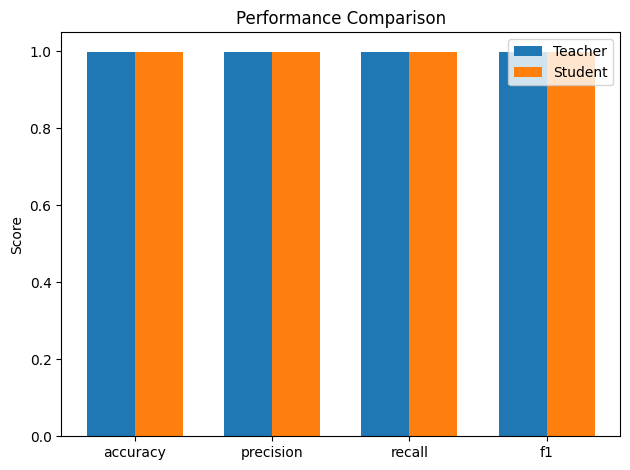

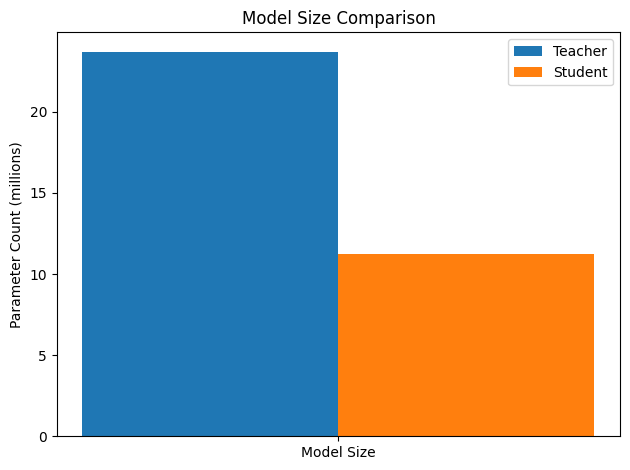

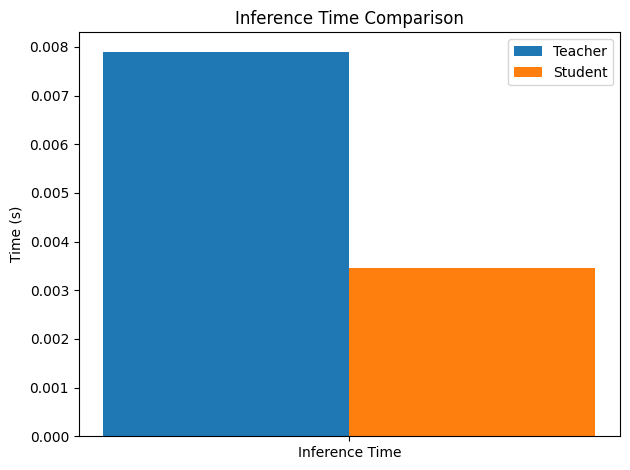

In [17]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (0.7991, 0.7349), 'precision': (0.8002562010387595, 0.7364789872112252), 'recall': (0.7991, 0.7349), 'f1': (0.7983668028973564, 0.734057798968803)}


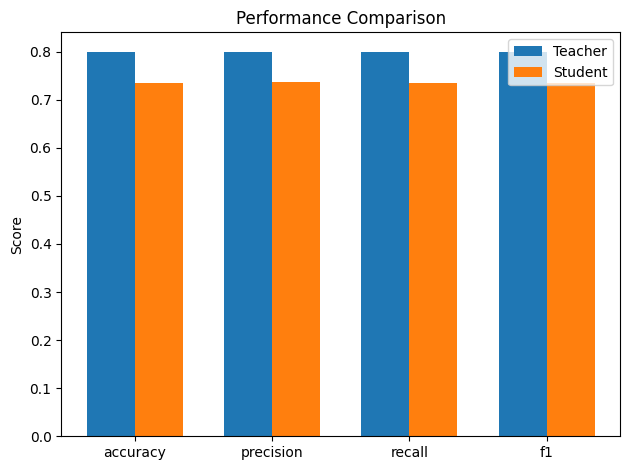

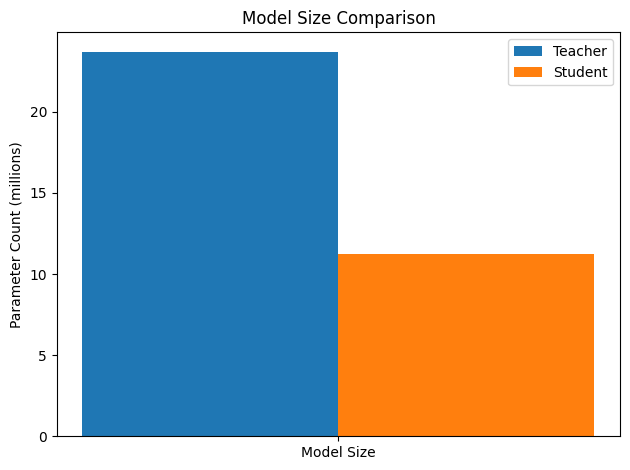

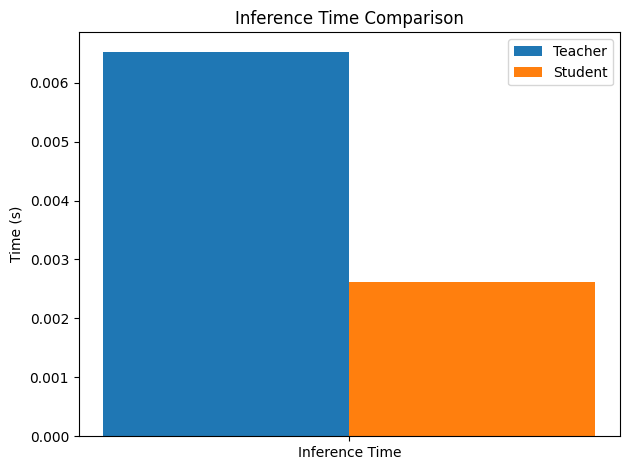

In [18]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')